Biblioteci necesare

In [1]:
!pip install tensorflow numpy matplotlib scikit-learn scipy requests tqdm opencv-python

Importuri si configurare

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
from tensorflow.keras import layers, models, optimizers, callbacks
from PIL import Image
import warnings

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

SEED = 2024
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print('Mediul de lucru:')
print(f'\t• TensorFlow: {tf.__version__}')
print(f'\t• Keras: {tf.keras.__version__}')
print(f'\t• NumPy: {np.__version__}')
print(f'\t• GPU disponibil: {"DA" if tf.config.list_physical_devices("GPU") else "NU"}')

Mediul de lucru:
	• TensorFlow: 2.18.0
	• Keras: 3.8.0
	• NumPy: 2.0.2
	• GPU disponibil: DA


Incarcare si pregatire dataset

In [3]:
def încarcă_dataset_flori(subset=False, num_clase=10):
    """
    Încarcă dataset-ul Oxford 102 Flowers folosind TensorFlow Datasets.

    Parametri:
    - subset: dacă True, folosește doar `num_clase` clase
    - num_clase: numărul de clase de folosit dacă subset=True

    Returnează tuple de (seturi de date, informații dataset)
    """
    import tensorflow_datasets as tfds

    tfds.disable_progress_bar()

    dataset, info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

    train_set = dataset['test']
    val_set = dataset['validation']
    test_set = dataset['train']

    num_train = info.splits['test'].num_examples
    num_val = info.splits['validation'].num_examples
    num_test = info.splits['train'].num_examples
    total_clase = info.features['label'].num_classes

    print('Statistici dataset:')
    print(f'Total clase: {total_clase}')
    print(f'Exemple antrenare: {num_train}')
    print(f'Exemple validare: {num_val}')
    print(f'Exemple testare: {num_test}')

    try:
        with open('label_map.json', 'r') as f:
            class_names = json.load(f)
    except:
        class_names = {str(i): f'Flower_{i}' for i in range(total_clase)}
        with open('label_map.json', 'w') as f:
            json.dump(class_names, f)

    if subset and num_clase < total_clase:
        print(f'Utilizăm doar {num_clase} clase din {total_clase}')

        def filtru_clase(img, label):
            return label < num_clase

        train_set = train_set.filter(filtru_clase)
        val_set = val_set.filter(filtru_clase)
        test_set = test_set.filter(filtru_clase)

        total_clase = num_clase

    return (train_set, val_set, test_set), info, total_clase, class_names

(train_set, val_set, test_set), dataset_info, num_classes, class_names = încarcă_dataset_flori(subset=False)

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Statistici dataset:
Total clase: 102
Exemple antrenare: 6149
Exemple validare: 1020
Exemple testare: 1020


Preprocesare + normalizare imagini

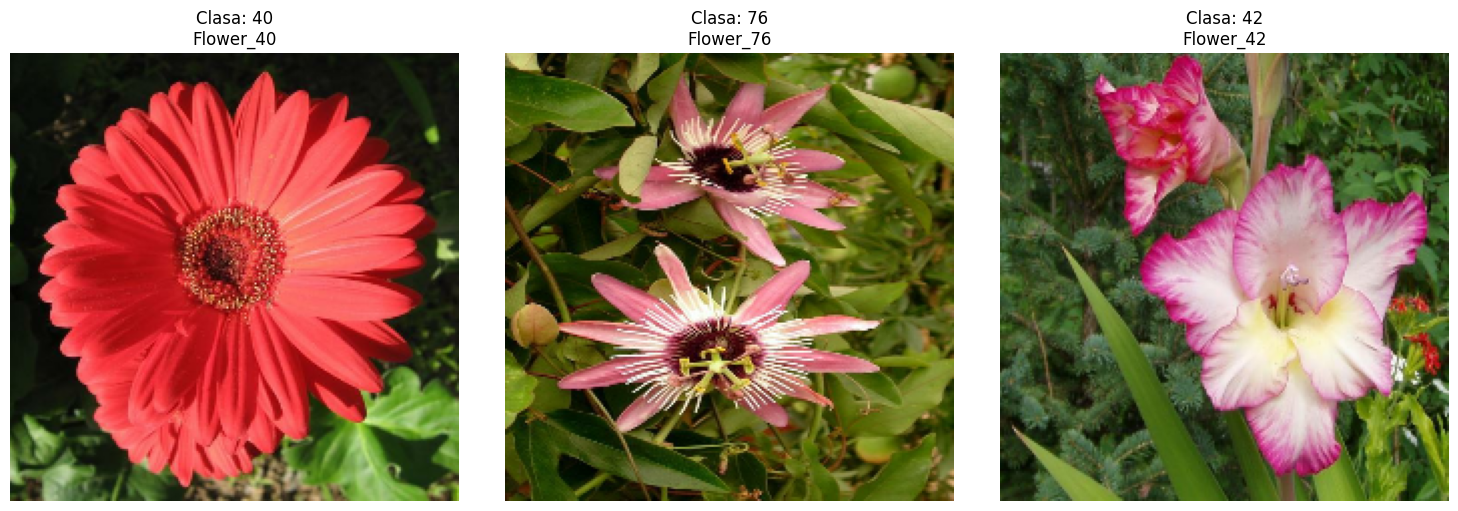

In [4]:
def normalizare_imagine(imagine, etichetă):
    """
    Normalizează și redimensionează imaginile pentru rețeaua neuronală.
    """
    imagine = tf.cast(imagine, tf.float32) / 255.0

    imagine = tf.image.resize(imagine, [224, 224])

    return imagine, etichetă

train_set = train_set.map(normalizare_imagine)
val_set = val_set.map(normalizare_imagine)
test_set = test_set.map(normalizare_imagine)

def vizualizează_imagini_dataset(set_date, class_names, num_imagini=3):
    """Afișează un număr specific de imagini din setul de date."""
    plt.figure(figsize=(15, 5))

    for i, (img, label) in enumerate(set_date.take(num_imagini)):
        plt.subplot(1, num_imagini, i+1)
        img = img.numpy()
        label = label.numpy()

        plt.imshow(img)
        plt.title(f'Clasa: {label}\n{class_names.get(str(label), "Necunoscut")}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

vizualizează_imagini_dataset(train_set, class_names)

Crearea pipeline date

In [5]:
def creare_pipeline_date(set_date, batch_size, shuffle_buffer=None):
    """
    Creează un pipeline eficient pentru datele de antrenare/validare/testare.

    Parametri:
    - set_date: setul de date TensorFlow
    - batch_size: dimensiunea batch-ului
    - shuffle_buffer: dacă e specificat, amestecă datele folosind acest buffer
    """
    pipeline = set_date.cache()

    if shuffle_buffer:
        pipeline = pipeline.shuffle(shuffle_buffer)

    pipeline = pipeline.batch(batch_size)
    pipeline = pipeline.prefetch(tf.data.experimental.AUTOTUNE)

    return pipeline

BATCH_SIZE = 64

train_size = dataset_info.splits['test'].num_examples
shuffle_size = train_size // 4

train_batches = creare_pipeline_date(train_set, BATCH_SIZE, shuffle_size)
val_batches = creare_pipeline_date(val_set, BATCH_SIZE)
test_batches = creare_pipeline_date(test_set, BATCH_SIZE)

Construire modelul CNN

In [6]:
def creeaza_model_flori_avansat(num_classes):
    """
    Creează un model CNN avansat de la zero pentru clasificarea florilor.
    Folosește tehnici moderne: BatchNormalization, regularizare, arhitectură graduală.
    """
    tf.keras.backend.clear_session()

    model = models.Sequential()

    model.add(layers.RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)))
    model.add(layers.RandomRotation(0.2))
    model.add(layers.RandomZoom(0.2))
    model.add(layers.RandomContrast(0.2))
    model.add(layers.RandomBrightness(0.1))

    model.add(layers.Conv2D(48, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.SpatialDropout2D(0.1))

    model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(96, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.SpatialDropout2D(0.1))

    model.add(layers.Conv2D(192, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(192, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.SpatialDropout2D(0.2))

    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.SpatialDropout2D(0.2))

    model.add(layers.Flatten())

    model.add(layers.Dense(1280, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(640, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(320, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0003)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = creeaza_model_flori_avansat(num_classes)
model.summary()

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 48)   │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 48)   │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 112, 112, 48)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 96)   │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 56, 56, 96)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 192)    │       331,96

 Total params: 100,047,830 (381.65 MB)

 Trainable params: 100,040,470 (381.62 MB)

 Non-trainable params: 7,360 (28.75 KB)

Antrenare model

Începem antrenarea modelului...

Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0124 - loss: 7.1980
Epoch 1: val_accuracy improved from -inf to 0.00980, saving model to flori_model_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.0124 - loss: 7.1976 - val_accuracy: 0.0098 - val_loss: 7.2067 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0153 - loss: 6.9850
Epoch 2: val_accuracy did not improve from 0.00980
97/97 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.0153 - loss: 6.9840 - val_accuracy: 0.0098 - val_loss: 6.5484 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0148 - loss: 6.6961
Epoch 3: val_accuracy did not improve from 0.00980
97/97 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - 

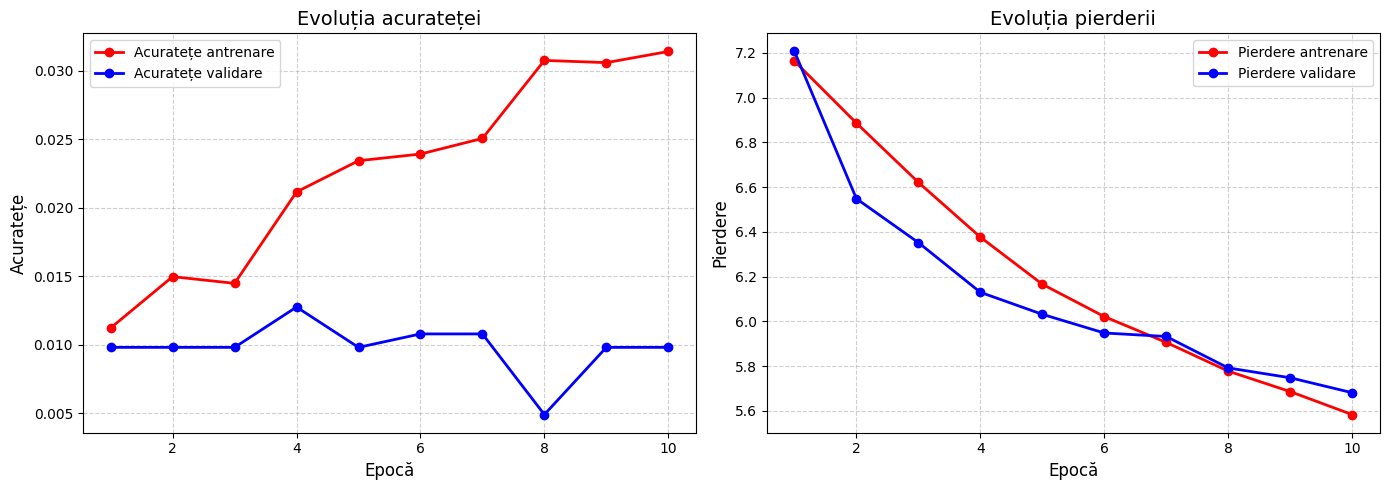

In [7]:
def configurare_callbacks():
    """Configurează callback-urile pentru antrenare."""
    model_checkpoint = callbacks.ModelCheckpoint(
        'flori_model_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    early_stop = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    def scheduler(epoch, lr):
        if epoch < 10:
            return 0.0005
        elif epoch < 40:
            return 0.001
        elif epoch < 70:
            return 0.0005
        else:
            return 0.0001

    lr_scheduler = callbacks.LearningRateScheduler(scheduler, verbose=1)

    return [model_checkpoint, early_stop, lr_scheduler]

NUM_EPOCI = 10

print("Începem antrenarea modelului...")
history = model.fit(
    train_batches,
    epochs=NUM_EPOCI,
    validation_data=val_batches,
    callbacks=configurare_callbacks(),
    verbose=1
)

def vizualizare_istorie_antrenare(istoric):
    """Afișează grafice cu acuratețea și pierderea în timpul antrenării."""
    acuratete = istoric.history['accuracy']
    val_acuratete = istoric.history['val_accuracy']
    pierdere = istoric.history['loss']
    val_pierdere = istoric.history['val_loss']
    epoci = range(1, len(acuratete) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoci, acuratete, 'ro-', label='Acuratețe antrenare', linewidth=2)
    plt.plot(epoci, val_acuratete, 'bo-', label='Acuratețe validare', linewidth=2)
    plt.title('Evoluția acurateței', fontsize=14)
    plt.xlabel('Epocă', fontsize=12)
    plt.ylabel('Acuratețe', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoci, pierdere, 'ro-', label='Pierdere antrenare', linewidth=2)
    plt.plot(epoci, val_pierdere, 'bo-', label='Pierdere validare', linewidth=2)
    plt.title('Evoluția pierderii', fontsize=14)
    plt.xlabel('Epocă', fontsize=12)
    plt.ylabel('Pierdere', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

vizualizare_istorie_antrenare(history)

 Evaluare modelul


Evaluăm modelul pe setul de testare...
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.0069 - loss: 6.1422
Acuratețe pe setul de test: 0.0127
Pierdere pe setul de test: 6.1349
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


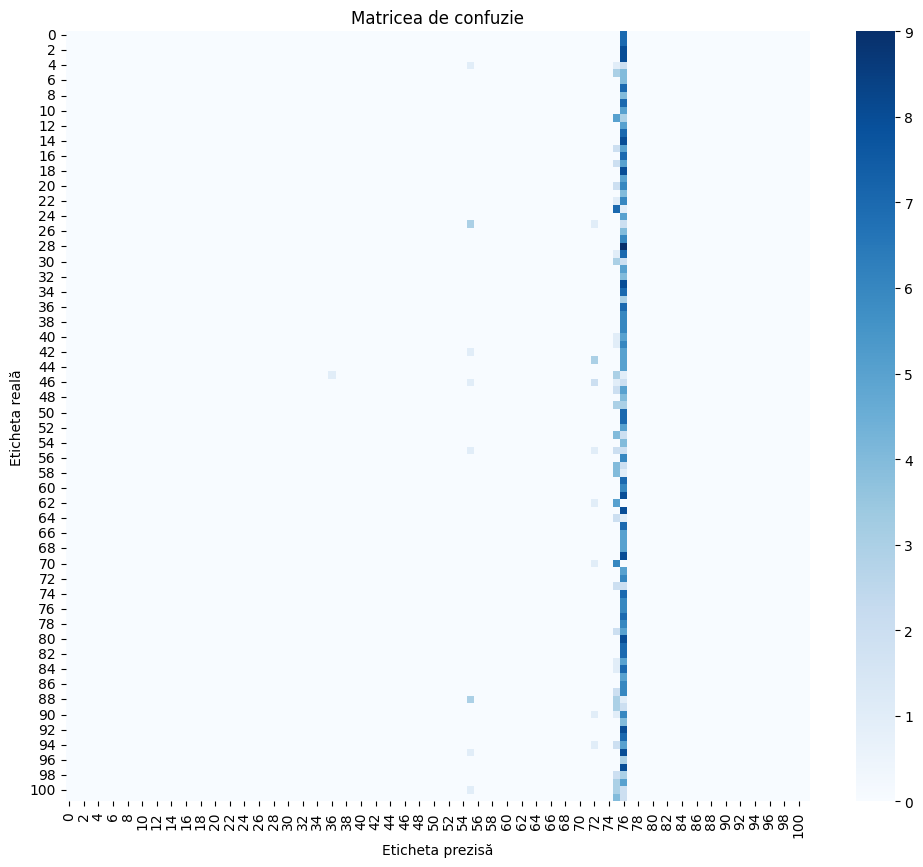

Raport de clasificare:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         7
          16       0.00      0.00      0.00         7
    

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
print("\nEvaluăm modelul pe setul de testare...")
test_loss, test_acc = model.evaluate(test_batches)
print(f'Acuratețe pe setul de test: {test_acc:.4f}')
print(f'Pierdere pe setul de test: {test_loss:.4f}')

def calculare_matrice_confuzie(model, set_date, clase):
    """Calculează și afișează matricea de confuzie."""
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    predictii = []
    etichete_reale = []

    for imagini, etichete in set_date:
        pred = model.predict(imagini)
        pred_clase = np.argmax(pred, axis=1)

        predictii.extend(pred_clase)
        etichete_reale.extend(etichete.numpy())

    cm = confusion_matrix(etichete_reale, predictii)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title("Matricea de confuzie")
    plt.ylabel("Eticheta reală")
    plt.xlabel("Eticheta prezisă")
    plt.show()

    print("Raport de clasificare:")
    print(classification_report(etichete_reale, predictii))

    return cm

subset_test = test_batches.take(10)
calculare_matrice_confuzie(model, subset_test, num_classes)

Predictie + Vizualizare

In [9]:
def prelucrare_imagine(cale_imagine):
    """Preia o imagine de pe disc și o pregătește pentru predicție."""
    imagine = Image.open(cale_imagine)
    imagine = imagine.resize((224, 224))
    imagine = np.array(imagine) / 255.0
    imagine = np.expand_dims(imagine, axis=0)
    return imagine

def predictie_floare(model, cale_imagine, class_names, top_k=5):
    """Prezice clasa unei imagini și returnează top_k predicții."""
    img = prelucrare_imagine(cale_imagine)

    predictions = model.predict(img)

    top_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_probs = predictions[0][top_indices]

    top_classes = [class_names.get(str(idx), f"Clasa {idx}") for idx in top_indices]

    return top_probs, top_indices, top_classes

def vizualizare_predictie(model, cale_imagine, class_names):
    """Vizualizează imaginea și predicțiile modelului."""
    probs, indices, classes = predictie_floare(model, cale_imagine, class_names)

    img = Image.open(cale_imagine)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Predicție: {classes[0]}', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probs, align='center')
    plt.yticks(y_pos, classes)
    plt.xlabel('Probabilitate')
    plt.title('Top 5 Predicții')
    plt.tight_layout()
    plt.show()

    print("Top predicții:")
    for i, (nume_clasa, prob) in enumerate(zip(classes, probs)):
        print(f"{i+1}. {nume_clasa}: {prob:.4f}")

Salvare + incarcare modelul

In [10]:
def salvare_model(model, director='modele'):
    """Salvează modelul în format TensorFlow SavedModel și TensorFlow Lite."""
    import datetime
    import os

    os.makedirs(director, exist_ok=True)

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(director, f'flower_model_{timestamp}')

    model.save(model_path + '.keras')
    print(f"Model salvat la: {model_path}.keras")

    input_shape = model.input_shape[1:]
    inference_model = models.Sequential()

    for layer in model.layers[5:]:
        inference_model.add(layer)

    inference_model.build((None,) + input_shape)

    for i, layer in enumerate(inference_model.layers):
        layer.set_weights(model.layers[i+5].get_weights())

    inference_model.save(model_path + '_inference.keras')
    print(f"Model de inferență salvat la: {model_path}_inference.keras")

    return model_path

model_path = salvare_model(model)

Model salvat la: modele/flower_model_20250508_220511.keras
Model de inferență salvat la: modele/flower_model_20250508_220511_inference.keras


Testare exemplu

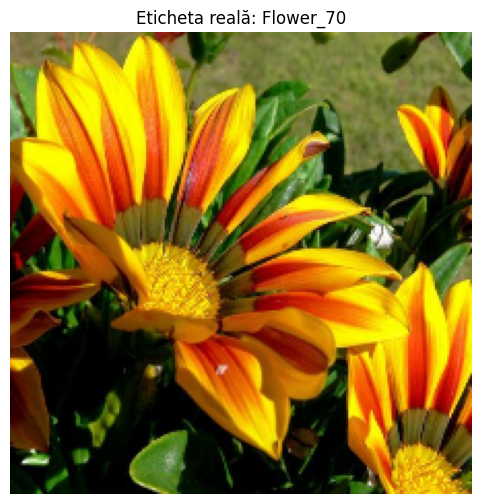

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Eticheta reală: 70 (Flower_70)
Predicție: 72 (Flower_72)
Probabilitate: 0.0205
✗ Predicție incorectă!


In [20]:
def test_pe_imagine_aleatoare_din_test():
    """Testează modelul pe o imagine aleatoare din setul de test."""
    import random
    import os
    import matplotlib.pyplot as plt
    from PIL import Image

    for imagini, etichete in test_batches.take(1):
        idx = random.randint(0, len(imagini) - 1)

        imagine = imagini[idx].numpy()
        eticheta = int(etichete[idx].numpy())

        plt.figure(figsize=(6, 6))
        plt.imshow(imagine)
        plt.title(f'Eticheta reală: {class_names.get(str(eticheta), "Necunoscut")}')
        plt.axis('off')
        plt.show()

        predictions = model.predict(np.expand_dims(imagine, axis=0))
        top_idx = np.argmax(predictions[0])

        print(f'Eticheta reală: {eticheta} ({class_names.get(str(eticheta), "Necunoscut")})')
        print(f'Predicție: {top_idx} ({class_names.get(str(top_idx), "Necunoscut")})')
        print(f'Probabilitate: {predictions[0][top_idx]:.4f}')

        if eticheta == top_idx:
            print("✓ Predicție corectă!")
        else:
            print("✗ Predicție incorectă!")

test_pe_imagine_aleatoare_din_test()